In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import pandas as pd
# df = pd.read_csv('/content/drive/MyDrive/genki4k/labels.csv')
# df

In [ ]:
# df.value_counts('class')

In [ ]:
# smile = df.iloc[:2162]
# smile.value_counts('class')

Model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (180, 180)
!rm -rf output

In [ ]:
PATH_OF_DATA = '/content/drive/My Drive/Face'

In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio(PATH_OF_DATA, output="output", seed=1337, ratio=(0.8, 0.2))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 4000 files [00:13, 287.72 files/s]


In [ ]:
train_dir = '/content/output/train'
validation_dir = '/content/output/val'

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 3199 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 801 files belonging to 2 classes.


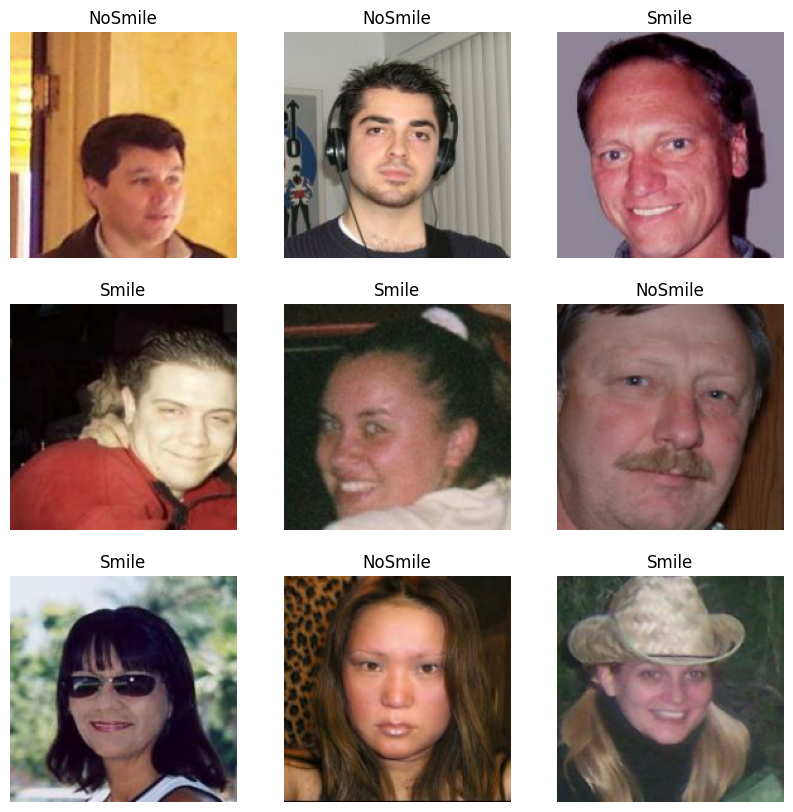

In [ ]:
class_names = validation_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 21
Number of test batches: 5


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomFlip('vertical'),
  tf.keras.layers.RandomRotation(0.2),
])

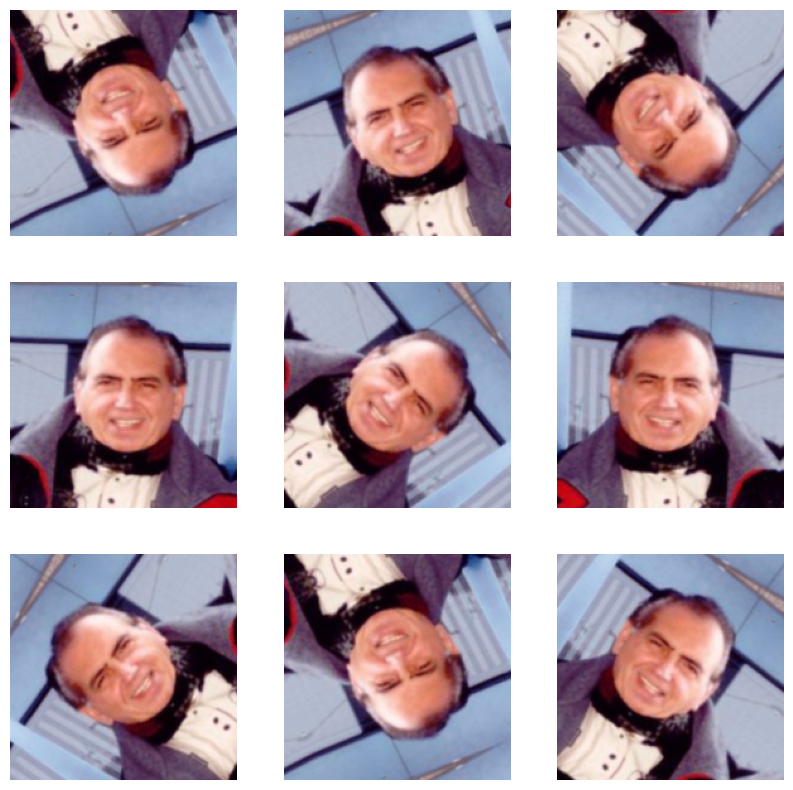

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.nasnet.preprocess_input

In [ ]:
# rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.nasnet.NASNetMobile(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1056)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 89, 89, 32)   864         ['input_25[0][0]']               
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 89, 89, 32)   128         ['stem_conv1[0][0]']             
                                                                                                  
 activation_564 (Activation)    (None, 89, 89, 32)   0           ['stem_bn1[0][0]']          

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

In [ ]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_16 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv_16 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_16 (TFOpLa  (None, 180, 180, 3)      0         
 mbda)                                                           
                                                                 
 NASNet (Functional)         (None, 6, 6, 1056)        4269716   
                                                                 
 global_average_pooling2d_12  (None, 1056)             0  

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
100/100 [==============================] - 27s 122ms/step - loss: 0.6210 - accuracy: 0.6333 - val_loss: 0.6071 - val_accuracy: 0.6334
Epoch 2/10
100/100 [==============================] - 8s 74ms/step - loss: 0.6220 - accuracy: 0.6358 - val_loss: 0.6162 - val_accuracy: 0.6193
Epoch 3/10
100/100 [==============================] - 8s 82ms/step - loss: 0.6102 - accuracy: 0.6530 - val_loss: 0.6169 - val_accuracy: 0.6162
Epoch 4/10
100/100 [==============================] - 8s 82ms/step - loss: 0.6141 - accuracy: 0.6461 - val_loss: 0.6185 - val_accuracy: 0.6256
Epoch 5/10
100/100 [==============================] - 8s 74ms/step - loss: 0.6160 - accuracy: 0.6421 - val_loss: 0.6057 - val_accuracy: 0.6240
Epoch 6/10
100/100 [==============================] - 8s 82ms/step - loss: 0.6096 - accuracy: 0.6430 - val_loss: 0.6183 - val_accuracy: 0.6100
Epoch 7/10
100/100 [==============================] - 8s 75ms/step - loss: 0.6069 - accuracy: 0.6483 - val_loss: 0.6014 - val_accuracy: 0.63

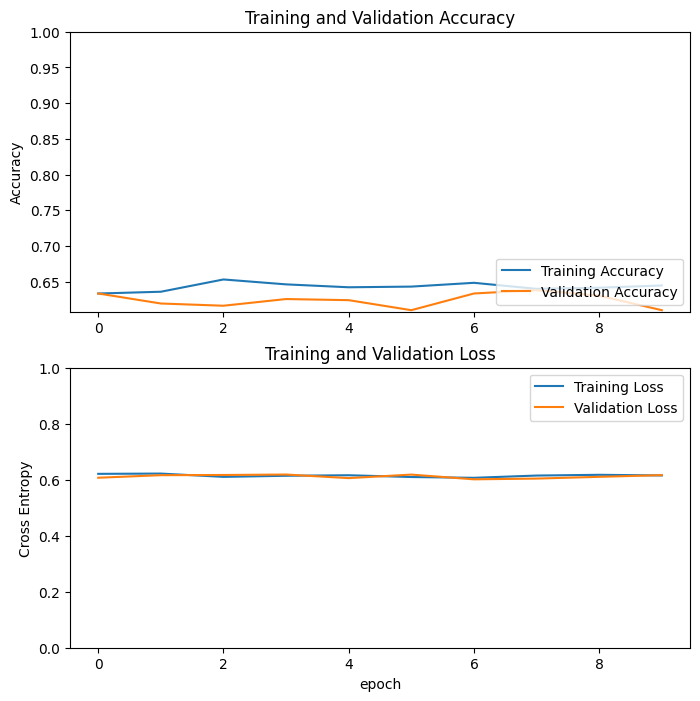

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 500

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  769


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_16 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv_16 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_16 (TFOpLa  (None, 180, 180, 3)      0         
 mbda)                                                           
                                                                 
 NASNet (Functional)         (None, 6, 6, 1056)        4269716   
                                                                 
 global_average_pooling2d_12  (None, 1056)             0  

In [ ]:
len(model.trainable_variables)

267

In [ ]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/25
100/100 [==============================] - 66s 186ms/step - loss: 0.6317 - accuracy: 0.5889 - val_loss: 0.6059 - val_accuracy: 0.6443
Epoch 11/25
100/100 [==============================] - 13s 125ms/step - loss: 0.6168 - accuracy: 0.6321 - val_loss: 0.5868 - val_accuracy: 0.6771
Epoch 12/25
100/100 [==============================] - 13s 123ms/step - loss: 0.6090 - accuracy: 0.6402 - val_loss: 0.6012 - val_accuracy: 0.6661
Epoch 13/25
100/100 [==============================] - 13s 128ms/step - loss: 0.5961 - accuracy: 0.6611 - val_loss: 0.6016 - val_accuracy: 0.6708
Epoch 14/25
100/100 [==============================] - 13s 125ms/step - loss: 0.5843 - accuracy: 0.6677 - val_loss: 0.5863 - val_accuracy: 0.6786
Epoch 15/25
100/100 [==============================] - 13s 124ms/step - loss: 0.5683 - accuracy: 0.6918 - val_loss: 0.5888 - val_accuracy: 0.7067
Epoch 16/25
100/100 [==============================] - 13s 125ms/step - loss: 0.5606 - accuracy: 0.6996 - val_loss: 0.5792 -

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

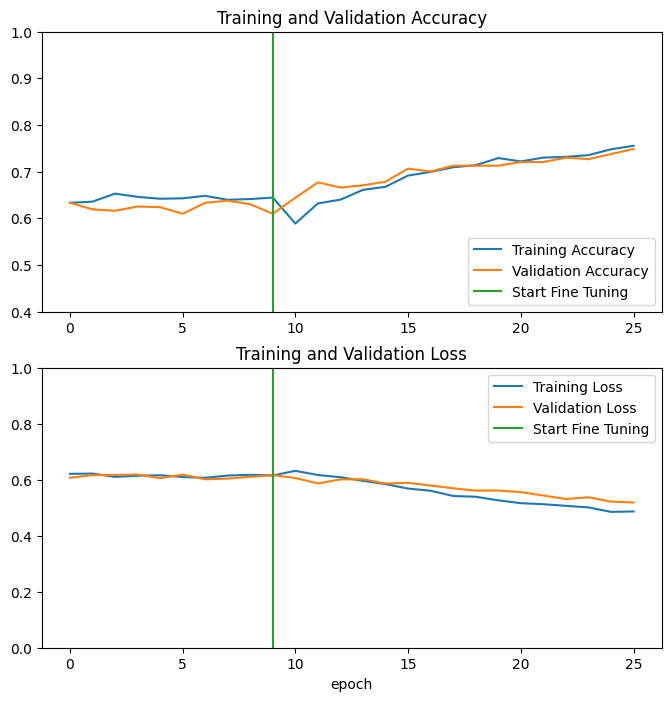

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()